In [1]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
import random

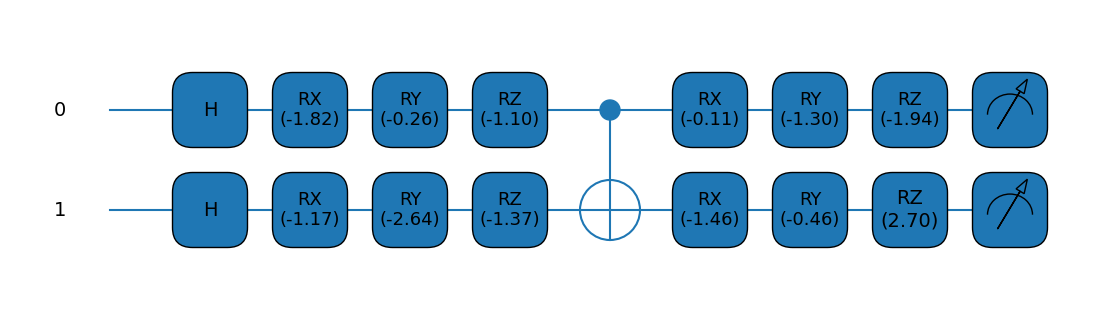

In [14]:
device = qml.device('qiskit.aer', wires=2, backend='qasm_simulator')
params = np.random.normal(0, np.pi/2, (2,6))
params = Variable(torch.tensor(params), requires_grad=True)

@qml.qnode(device, interface="torch")
def circuit(x, M=None):
    qml.Hadamard(wires=0)
    qml.RX(x[0][0], wires=0)
    qml.RY(x[0][1], wires=0)
    qml.RZ(x[0][2], wires=0)
    qml.Hadamard(wires=1)
    qml.RX(x[1][0], wires=1)
    qml.RY(x[1][1], wires=1)
    qml.RZ(x[1][2], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RX(x[0][3], wires=0)
    qml.RY(x[0][4], wires=0)
    qml.RZ(x[0][5], wires=0)
    qml.RX(x[1][3], wires=1)
    qml.RY(x[1][4], wires=1)
    qml.RZ(x[1][5], wires=1)
    return  qml.expval(qml.Hermitian(M, wires=[0,1]))

fig, ax = qml.draw_mpl(circuit, decimals=2)(params)
plt.show()

In [15]:
p01 = random.random()
p23 = 1 - p01

c=random.random()
p0 = c*p01
p1 = (1-c)*p01
c= random.random()
p2 = c*p23
p3 = (1-c)*p23

a00 = p0**0.5
a01 = p1**0.5
a10 = p2**0.5
a11 = p3**0.5

from rdmg import rdm_ginibre

def multi_state_fidelity(n_qb):
    d = 2**n_qb
    target_state = rdm_ginibre(d)
    print(np.trace(np.dot(target_state,target_state)))
    target_op = torch.tensor(target_state)
    return target_op


target_state = np.array([a00,a01,a10,a11])
target_op = np.outer(target_state.conj(), target_state)
target_op = torch.tensor(target_op)
print(target_state)
target_op = multi_state_fidelity(2)
print(target_op)

[0.90632203 0.34504378 0.07486176 0.23220871]
(0.4600975571443703+0j)
tensor([[ 0.4355+0.0000j, -0.1917+0.1063j,  0.0604-0.0809j,  0.0023+0.0051j],
        [-0.1917-0.1063j,  0.3272+0.0000j, -0.0230+0.0543j,  0.0008-0.0092j],
        [ 0.0604+0.0809j, -0.0230-0.0543j,  0.0824+0.0000j, -0.0280+0.0607j],
        [ 0.0023-0.0051j,  0.0008+0.0092j, -0.0280-0.0607j,  0.1548+0.0000j]],
       dtype=torch.complex128)


In [16]:
def cost(params):
    L = (1-circuit(params, M=target_op))**2
    return L

In [17]:
opt = torch.optim.Adam([params], lr=0.1)
best_loss = 1*cost(params)
best_params = 1*params

In [18]:
for epoch in range(64):
    opt.zero_grad()
    loss = cost(params)
    loss.backward()
    opt.step()
    print(epoch, loss)
    
    if loss < best_loss:
        best_loss = 1*loss
        best_params = 1*params

0 tensor(0.4637, dtype=torch.float64, grad_fn=<PowBackward0>)
1 tensor(0.4146, dtype=torch.float64, grad_fn=<PowBackward0>)
2 tensor(0.3360, dtype=torch.float64, grad_fn=<PowBackward0>)
3 tensor(0.3173, dtype=torch.float64, grad_fn=<PowBackward0>)
4 tensor(0.2750, dtype=torch.float64, grad_fn=<PowBackward0>)
5 tensor(0.2346, dtype=torch.float64, grad_fn=<PowBackward0>)
6 tensor(0.2216, dtype=torch.float64, grad_fn=<PowBackward0>)
7 tensor(0.1824, dtype=torch.float64, grad_fn=<PowBackward0>)
8 tensor(0.1738, dtype=torch.float64, grad_fn=<PowBackward0>)
9 tensor(0.1585, dtype=torch.float64, grad_fn=<PowBackward0>)
10 tensor(0.1504, dtype=torch.float64, grad_fn=<PowBackward0>)
11 tensor(0.1479, dtype=torch.float64, grad_fn=<PowBackward0>)
12 tensor(0.1458, dtype=torch.float64, grad_fn=<PowBackward0>)
13 tensor(0.1439, dtype=torch.float64, grad_fn=<PowBackward0>)
14 tensor(0.1528, dtype=torch.float64, grad_fn=<PowBackward0>)
15 tensor(0.1481, dtype=torch.float64, grad_fn=<PowBackward0>)
16

In [19]:
print(best_loss)
print(best_params)
print('Fidelidade: ', circuit(best_params, M=target_op).item())

tensor(0.1376, dtype=torch.float64, grad_fn=<MulBackward0>)
tensor([[-2.3070, -1.5452,  0.8044, -0.2425,  0.2992,  0.3780],
        [-2.3260, -2.0438, -2.4182, -1.2048, -0.9596,  2.2188]],
       dtype=torch.float64, grad_fn=<MulBackward0>)
Fidelidade:  0.6265921581412617


In [9]:
device = qml.device('qiskit.aer', wires=2, backend='qasm_simulator', shots=8192)
@qml.qnode(device, interface="torch")
def circuit2(x, M=None):
    qml.Hadamard(wires=0)
    qml.RX(x[0][0], wires=0)
    qml.RY(x[0][1], wires=0)
    qml.RZ(x[0][2], wires=0)
    qml.Hadamard(wires=1)
    qml.RX(x[1][0], wires=1)
    qml.RY(x[1][1], wires=1)
    qml.RZ(x[1][2], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RX(x[0][3], wires=0)
    qml.RY(x[0][4], wires=0)
    qml.RZ(x[0][5], wires=0)
    qml.RX(x[1][3], wires=1)
    qml.RY(x[1][4], wires=1)
    qml.RZ(x[1][5], wires=1)
    return  qml.probs(wires=[0,1])


In [10]:
counts = circuit2(best_params, M=target_op)

In [11]:
prepared_state = counts.detach().numpy()**0.5
print(target_state)
print(prepared_state)
print(np.outer(prepared_state,prepared_state))

[0.74260122 0.42930523 0.41662466 0.30110518]
[0.63208871 0.44770465 0.54609319 0.31907153]
[[0.39953613 0.28298905 0.34517934 0.20168151]
 [0.28298905 0.20043945 0.24448846 0.14284981]
 [0.34517934 0.24448846 0.29821777 0.17424279]
 [0.20168151 0.14284981 0.17424279 0.10180664]]
